<h2>Descriptive and Exploratory Analysis of NYC Taxi Trip Distances</h2>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #pretty print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<i><b>1. Let's first load the dataset and print out the its size</b></i>

In [2]:
data = pd.read_csv('jul16_sample.csv')

# Print the size of the dataset
print("Number of rows:", data.shape[0])
print("Number of columns: ", data.shape[1])

Number of rows: 329114
Number of columns:  18


<i><b>2. Let's have a look at the distribution of trip distance</i></b>

In [4]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329114 entries, 0 to 329113
Data columns (total 18 columns):
Unnamed: 0               329114 non-null int64
VendorID                 329114 non-null int64
tpep_pickup_datetime     329114 non-null object
tpep_dropoff_datetime    329114 non-null object
passenger_count          329114 non-null int64
trip_distance            329114 non-null float64
RatecodeID               329114 non-null int64
store_and_fwd_flag       329114 non-null object
PULocationID             329114 non-null int64
DOLocationID             329114 non-null int64
payment_type             329114 non-null int64
fare_amount              329114 non-null float64
extra                    329114 non-null float64
mta_tax                  329114 non-null float64
tip_amount               329114 non-null float64
tolls_amount             329114 non-null float64
improvement_surcharge    329114 non-null float64
total_amount             329114 non-null float64
dtypes: float64(8), int6

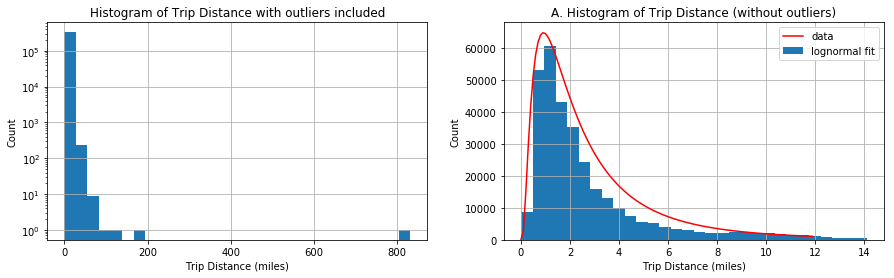

In [3]:
# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
data.trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance with outliers included')

# create a vector to contain Trip Distance
v = data.trip_distance 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v[~((v-v.median()).abs()>3*v.std())].hist(bins=30,ax=ax[1]) # 
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Distance (without outliers)')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(data.trip_distance.values,
                               scale=data.trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0, 12, 0.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),200000*pdf_fitted,'r') 
ax[1].legend(['data','lognormal fit'])

# export the figure
plt.savefig('Question2.jpeg',format='jpeg')
plt.show()

The Trip Distance is asymmetrically distributed. It is skewed to the right and it has a median smaller than its mean and both smaller than the standard deviation. The skewness is due to the fact that the variable has a lower boundary of 0. The distance can't be negative. This distribution has a structure of a lognormal distribution. To the left is plotted the distribution of the entire raw set of Trip distance. To the right, outliers have been removed before plotting. (outliers are defined as any point located further than 3 standard deviations from the mean)

<b>The hypothesis: The trips are not random.</b> If there were random, we would have a (symmetric) Gaussian distribution. The non-zero autocorrelation may be related the fact that people taking ride are pushed by a common cause, for instance, people rushing to work.

<i><b>3. Let's see if the time of the day has any impact on the trip distance</i></b>

In [5]:
# First, convert pickup and drop off datetime variable in their specific righ format
data['Pickup_dt'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a variable for pickup hours
data['Pickup_hour'] = data.Pickup_dt.apply(lambda x:x.hour)

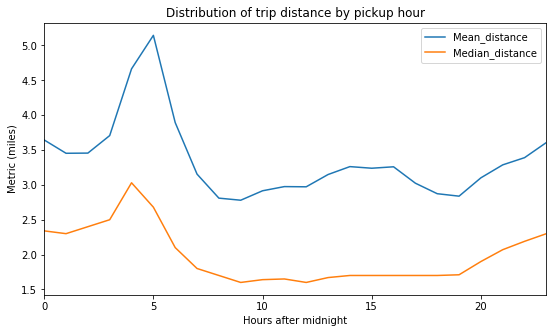

Trip distance by hour of the day

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.64441               2.34
     1          3.45345               2.3
     2          3.45597               2.4
     3          3.70742               2.5
     4          4.66482               3.03
     5          5.14551               2.68
     6          3.8936                2.1
     7          3.15428               1.8
     8          2.80974               1.7
     9          2.77982               1.6
    10          2.91533               1.64
    11          2.97528               1.65
    12          2.97242               1.6
    13          3.14851               1.67
    14          3.26211               1.7
    15          3.23893               1.7
    16          3.25952               1.7
    17          3.02411               1.7
    18          2.87335               1.7
    19          2.83803               1.71
    20          3.10125          

In [6]:
# Mean and Median of trip distance by pickup hour
# I will generate the table but also generate a plot for a better visualization

fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = data.pivot_table(index='Pickup_hour', values='trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip distance by pickup hour')
#plt.xticks(np.arange(0,30,6)+0.35,range(0,30,6))
plt.xlim([0,23])
plt.savefig('Question3_1.jpeg',format='jpeg')
plt.show()
print('Trip distance by hour of the day\n')
print(tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

We observe long range trips in the early mornings (5am being longest) and evenings. I think those distances are not mainly caused by work commutes, since the morning distances are longer than the evenings. It's possible that people are okay to take cabs in the morning to avoid being late to works, while they would rather take public transportation in the evening, but it still needs further profs.

<i><b>4. Let's also compare trips that originate (or terminate) from one of the NYC airports. We can look at how many they are, the average fair and average tip, etc.</i></b>

Reading through the dictionary of variables, I found that the variable RateCodeID contains values indicating the final rate that was applied. Among those values, I realized that there is Newark and JFK which are the major airports in New York. In this part, I will use this knowledge and group data with RateCodeID 2 (JFK) and 3 (Newark). - An alternative (which I didn't due to time constraint) is to (1) get coordinates of airports from google map or http://transtats.bts.gov (2) get at least 4 points defining a rectangular buffer zone near the airport (3) build a polygon shape using shapely [https://pypi.python.org/pypi/Shapely] and (3) check if any pickup/dropoff location coordinates is within the polygon using shapely again.

In [11]:
# select airport trips
airports_trips = data[(data.RatecodeID==2) | (data.RatecodeID==3)]
print("Number of trips to/from NYC airports: \n", airports_trips.shape[0],"\n")
print("Average fare (calculated by the meter) of trips to/from NYC airports: $\n", airports_trips.fare_amount.mean(),"per trip\n")
print("Average total charged amount of trips to/from NYC airports: $\n", airports_trips.total_amount.mean(),"per trip\n")
print("Average tip amount of trips to/from NYC airports: $\n", airports_trips.tip_amount.mean(),"per trip\n")

Number of trips to/from NYC airports: 
 8200 

Average fare (calculated by the meter) of trips to/from NYC airports: $
 53.566809756097555 per trip

Average total charged amount of trips to/from NYC airports: $
 70.5210121951237 per trip

Average tip amount of trips to/from NYC airports: $
 10.390826829268123 per trip



<i><b>5. In addition to the number and mean fare of airport trips, let's have aso look at how trips are distributed by trip distances and hour of the day</i></b>

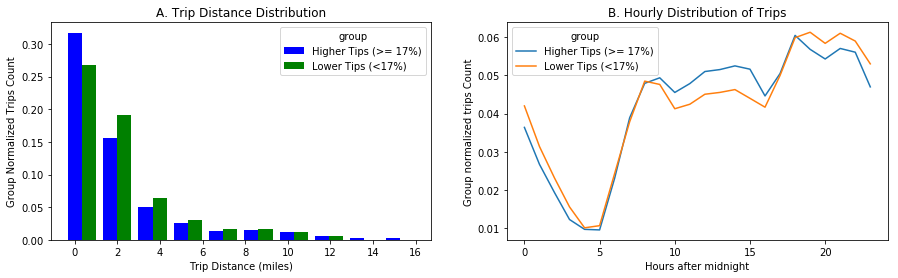

In [17]:
higher_tips = data[(data.isHighTip==1)]
# create a vector to contain Trip Distance for
v2 = higher_tips.trip_distance # airport trips
v3 = data.loc[~data.index.isin(v2.index),'trip_distance'] # non-airport trips

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Higher Tips (>= 17%)','Lower Tips (<17%)'],loc='best',title='group')
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Group Normalized Trips Count')
ax[0].set_title('A. Trip Distance Distribution')
#ax[0].set_yscale('log')

# plot hourly distribution
higher_tips.Pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
data.loc[~data.index.isin(v2.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips Count')
ax[1].set_title('B. Hourly Distribution of Trips')
ax[1].legend(['Higher Tips (>= 17%)','Lower Tips (<17%)'],loc='best',title='group')
plt.show()

<b>Key findings:</b>

A. The trip distance distribution shows two peaks. Airport trips follow the same trend as the rest of the trips for short trips (trip distance ≤ 2miles). However, there is also an increased number of long range trips (18 miles) which might correspond to a great number people coming to airports from further residential areas. <i>A check on google map shows that the distance between JFK and Manhattan is about 18 miles whereas Newark to Manhattan is 15 miles.</i>

B. The hourly distribution shows that the number of trips at airports peaks around 4PM while it peaks 2 hours later. On the other hand, there is a shortage in airports riders at 4AM while the rest of NYC goes completely down 1 hours earlier 3AM.

In [24]:
def createNewVariables(data):
    print('deriving time variables')
    # Rename the datatime columns to 'Pickup_dt' and 'Dropoff_dt'
    data.rename(columns={'tpep_pickup_datetime':'Pickup_dt','tpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    # Convert it to the right format
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    # Derive time variables - time of day, day of week, day of month, month
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
    data['Month'] = data.Pickup_dt.apply(lambda x:x.month)
    
    # Create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
    data['Shift_type'] = np.NAN
    data.loc[data[(data.Hour>=7) & (data.Hour<15)].index,'Shift_type'] = 1
    data.loc[data[(data.Hour>=15) & (data.Hour<23)].index,'Shift_type'] = 2
    data.loc[data[data.Shift_type.isnull()].index,'Shift_type'] = 3
    
    print('deriving trip duration and speed')
    # Trip duration 
    data['Trip_duration_min'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    # Speed
    data['Speed_mph'] = data.trip_distance/(data.Trip_duration_min/60)
    # replace all NaNs values and values >240mph by a values sampled from a random distribution of 
    # mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution
    indices_oi = data[(data.Speed_mph.isnull()) | (data.Speed_mph>240)].index
    data.loc[indices_oi,'Speed_mph'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
    
    print('deriving tip variables')
    # create tip percentage variable
    data['tip_percentage'] = 100*data.tip_amount/data.total_amount
    # create with_tip variable
    data['with_tip'] = (data.tip_percentage>0)*1
    
    print('deriving airport trip variable')
    # Create airport_trip variable
    # 1 means it is a trip to/from NYC airports(JFK or Newark), 0 means non-airport trips
    data['airport_trip'] = np.NAN
    data.loc[data[(data.RatecodeID == 2) | (data.RatecodeID==3)].index,'airport_trip'] = 1
    data.loc[data[data.airport_trip.isnull()].index, 'airport_trip'] = 0
    
    return data

In [23]:
data['tip_percentage'] = 100*data.tip_amount/data.total_amount

In [22]:
data.loc[data[(data.trip_distance >= 2)].index,'isLongDistance'] = 1
data.loc[data[(data.trip_distance < 2)].index,'isLongDistance'] = 0
data.loc[data[(data.tip_amount / data.total_amount >= 0.17)].index,'isHighTip'] = 1
data.loc[data[(data.tip_amount / data.total_amount < 0.17)].index,'isHighTip'] = 0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329114 entries, 0 to 329113
Data columns (total 24 columns):
Unnamed: 0               329114 non-null int64
VendorID                 329114 non-null int64
tpep_pickup_datetime     329114 non-null object
tpep_dropoff_datetime    329114 non-null object
passenger_count          329114 non-null int64
trip_distance            329114 non-null float64
RatecodeID               329114 non-null int64
store_and_fwd_flag       329114 non-null object
PULocationID             329114 non-null int64
DOLocationID             329114 non-null int64
payment_type             329114 non-null int64
fare_amount              329114 non-null float64
extra                    329114 non-null float64
mta_tax                  329114 non-null float64
tip_amount               329114 non-null float64
tolls_amount             329114 non-null float64
improvement_surcharge    329114 non-null float64
total_amount             329114 non-null float64
Pickup_dt               

In [18]:
def visualize_continuous(df,label,method={'type':'histogram','bins':20},outlier='on'):
    """
    function to quickly visualize continous variables
    df: pandas.dataFrame 
    label: str, name of the variable to be plotted. It should be present in df.columns
    method: dict, contains info of the type of plot to generate. It can be histogram or boxplot [-Not yet developped]
    outlier: {'on','off'}, Set it to off if you need to cut off outliers. Outliers are all those points
    located at 3 standard deviations further from the mean
    """
    # create vector of the variable of interest
    v = df[label]
    # define mean and standard deviation
    m = v.mean()
    s = v.std()
    # prep the figure
    fig,ax = plt.subplots(1,2,figsize=(14,4))
    ax[0].set_title('Distribution of '+label)
    ax[1].set_title('Tip % by '+label)
    if outlier=='off': # remove outliers accordingly and update titles
        v = v[(v-m)<=3*s]
        ax[0].set_title('Distribution of '+label+'(no outliers)')
        ax[1].set_title('Tip % by '+label+'(no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins = method['bins'],ax=ax[0])
    if method['type'] == 'boxplot': # plot the box plot
        df.loc[v.index].boxplot(label,ax=ax[0])
    ax[1].plot(v,df.loc[v.index].tip_percentage,'.',alpha=0.4)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Tip (%)')

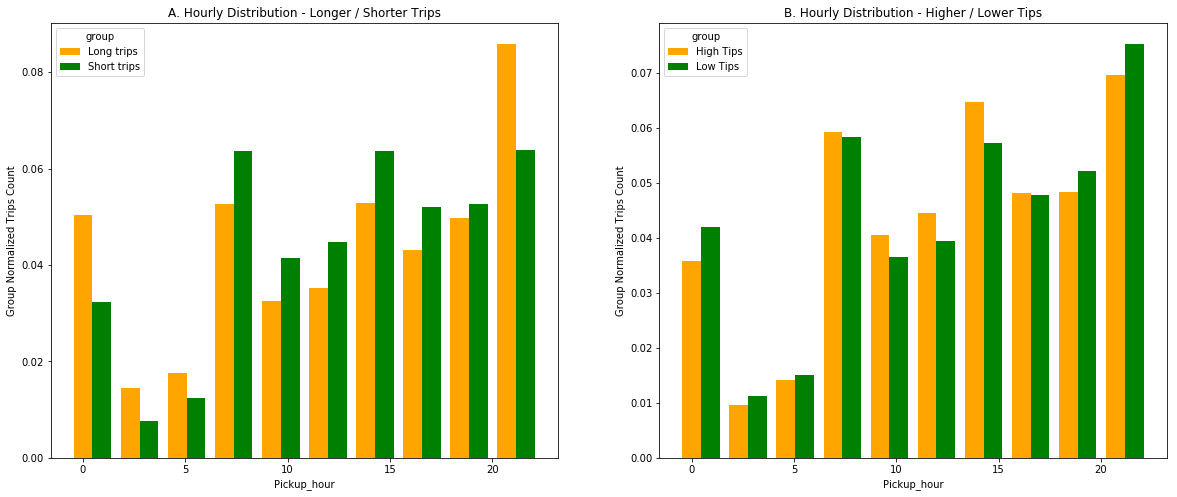

In [47]:
longer_trips = data[(data.isLongDistance==1)]
higher_tips = data[(data.isHighTip==1)]
# create a vector to contain Trip Distance for
v2 = longer_trips.Pickup_hour
v3 = data.loc[~data.index.isin(v2.index),'Pickup_hour']
v4 = higher_tips.Pickup_hour
v5 = data.loc[~data.index.isin(v4.index),'Pickup_hour']

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 
v4 = v4[~((v4-v4.median()).abs()>3*v4.std())]
v5 = v5[~((v5-v5.median()).abs()>3*v5.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

bins1 = np.histogram(v4,normed=True)[1]
h4 = np.histogram(v4,bins=bins,normed=True)
h5 = np.histogram(v5,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (20,8))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='orange')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='green')
ax[0].legend(['Long trips','Short trips'],loc='best',title='group')
ax[0].set_xlabel('Pickup_hour')
ax[0].set_ylabel('Group Normalized Trips Count')
ax[0].set_title('A. Hourly Distribution - Longer / Shorter Trips')

w1 = .4*(bins1[1]-bins1[0])
ax[1].bar(bins[:-1],h4[0],alpha=1,width=w1,color='orange')
ax[1].bar(bins[:-1]+w,h5[0],alpha=1,width=w1,color='green')
ax[1].legend(['High Tips','Low Tips'],loc='best',title='group')
ax[1].set_xlabel('Pickup_hour')
ax[1].set_ylabel('Group Normalized Trips Count')
ax[1].set_title('B. Hourly Distribution - Higher / Lower Tips')

In [21]:
import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64820 entries, 0 to 64819
Data columns (total 21 columns):
Unnamed: 0               64820 non-null int64
VendorID                 64820 non-null int64
tpep_pickup_datetime     64820 non-null object
tpep_dropoff_datetime    64820 non-null object
passenger_count          64820 non-null int64
trip_distance            64820 non-null float64
RatecodeID               64820 non-null int64
store_and_fwd_flag       64820 non-null object
PULocationID             64820 non-null int64
DOLocationID             64820 non-null int64
payment_type             64820 non-null int64
fare_amount              64820 non-null float64
extra                    64820 non-null float64
mta_tax                  64820 non-null float64
tip_amount               64820 non-null float64
tolls_amount             64820 non-null float64
improvement_surcharge    64820 non-null float64
total_amount             64820 non-null float64
Pickup_dt                64820 non-null date

In [22]:
# help function


def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.tpep_pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.tpep_pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.tpep_pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.tpep_pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.tpep_pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.tpep_dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.tpep_dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.tpep_dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.tpep_dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get weekday
import calendar

def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_.tpep_pickup_datetime).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['tpep_dropoff_datetime']) - pd.to_datetime(df_['tpep_pickup_datetime'])
    return df_

In [23]:
df_train_ = basic_feature_extract(data)
df_train_ = get_duration(data)
df_train_ = get_weekday(data)
df_train_['trip_duration_cal'] = pd.to_datetime(df_train_['tpep_dropoff_datetime']) - pd.to_datetime(df_train_['tpep_pickup_datetime'])
df_train_['trip_duration'] = df_train_['trip_duration_cal'] / np.timedelta64(1, 's')

In [24]:
df_train_['average_speed'] = df_train_["trip_distance"] / df_train_['trip_duration'] *60*60

In [25]:
df_train_.head(2)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,Dropoff_dt,Pickup_hour,tip_percentage,isLongDistance,isHighTip,pickup_week_,pickup_weekday_,trip_duration_cal,trip_duration,average_speed
0,7709480,2,2016-07-24 13:33:17,2016-07-24 13:40:49,1,1.23,1,N,234,170,...,2016-07-24 13:40:49,13,11.363636,0.0,0.0,6,Sunday,00:07:32,452.0,9.79646
1,6197707,2,2016-07-20 15:46:55,2016-07-20 15:52:58,2,1.07,1,N,236,75,...,2016-07-20 15:52:58,15,18.888889,0.0,1.0,2,Wednesday,00:06:03,363.0,10.61157


<h3>Distance vs. Speed</h3>

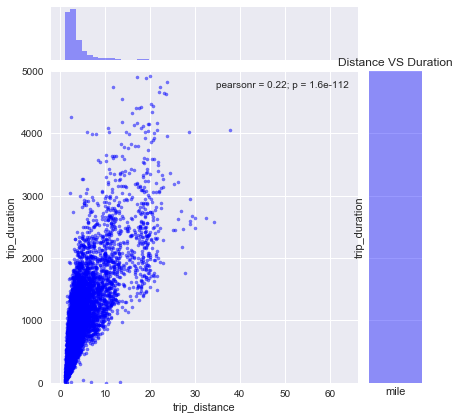

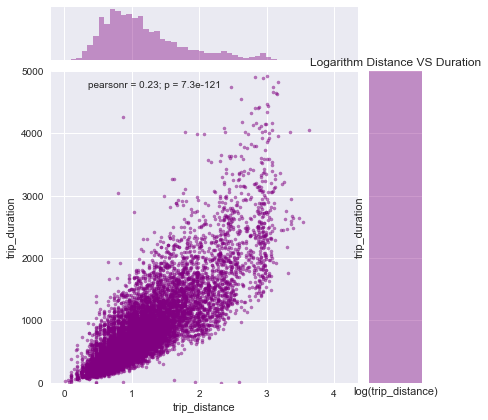

In [28]:
# distance VS duration 
sns.jointplot((df_train_["trip_distance"][:10000]+1),(df_train_["trip_duration"][:10000]+1),s=10,alpha=0.5,color='blue')
plt.xlabel('mile')
plt.ylabel('trip_duration')
plt.xlim(0,30)
plt.ylim(0,5000)
plt.title('Distance VS Duration')
plt.show()

# log distance VS duration 
sns.jointplot(np.log(df_train_["trip_distance"][:10000]+1),(df_train_["trip_duration"][:10000]+1),s=10,alpha=0.5,color='purple')
plt.xlim(0,30)
plt.ylim(0,5000)
plt.title('Logarithm Distance VS Duration')
plt.xlabel('log(trip_distance)')
plt.ylabel('trip_duration')
plt.show()

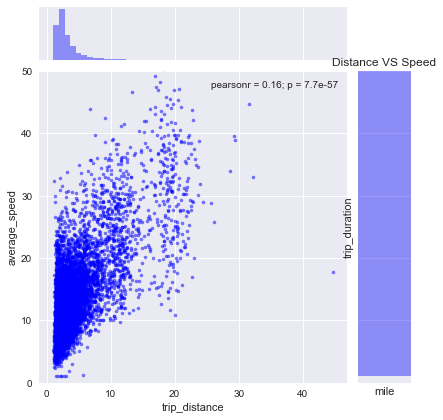

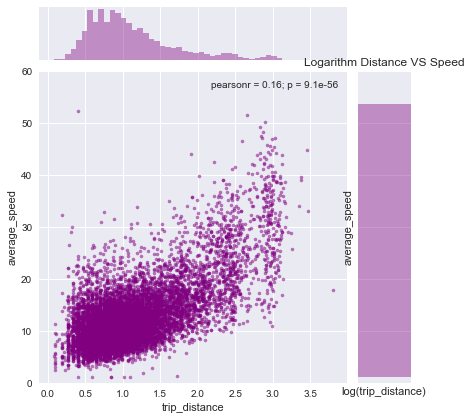

In [62]:
# distance VS speed
sns.jointplot((df_train_["trip_distance"][:10000]+1),(df_train_["average_speed"][:10000]+1),s=10,alpha=0.5,color='blue')
plt.xlabel('mile')
plt.ylabel('trip_duration')
plt.xlim(0,100)
plt.ylim(0,50)
plt.title('Distance VS Speed')
plt.show()

# log distance VS speed
sns.jointplot(np.log(df_train_["trip_distance"][:10000]+1),(df_train_["average_speed"][:10000]+1),s=10,alpha=0.5,color='purple')
plt.xlim(0,100)
plt.ylim(0,60)
plt.title('Logarithm Distance VS Speed')
plt.xlabel('log(trip_distance)')
plt.ylabel('average_speed')
plt.show()

<h3>Location Heatmap</h3>

In [7]:
loc_lookup = pd.read_csv('taxi+_zone_lookup.csv')

In [26]:
# join dataset with location_lookup on pick-up locationID
data_pu = data.join(loc_lookup.set_index('LocationID'), on='PULocationID')
data_pu.rename(columns={'Borough': 'pu_borough', 'Zone': 'pu_zone','service_zone':'pu_service_zone'}, inplace=True)
data = data_pu.join(loc_lookup.set_index('LocationID'), on='DOLocationID')
data.rename(columns={'Borough': 'do_borough', 'Zone': 'do_zone','service_zone':'do_service_zone'}, inplace=True)


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329114 entries, 0 to 329113
Data columns (total 30 columns):
Unnamed: 0               329114 non-null int64
VendorID                 329114 non-null int64
tpep_pickup_datetime     329114 non-null object
tpep_dropoff_datetime    329114 non-null object
passenger_count          329114 non-null int64
trip_distance            329114 non-null float64
RatecodeID               329114 non-null int64
store_and_fwd_flag       329114 non-null object
PULocationID             329114 non-null int64
DOLocationID             329114 non-null int64
payment_type             329114 non-null int64
fare_amount              329114 non-null float64
extra                    329114 non-null float64
mta_tax                  329114 non-null float64
tip_amount               329114 non-null float64
tolls_amount             329114 non-null float64
improvement_surcharge    329114 non-null float64
total_amount             329114 non-null float64
Pickup_dt               

In [38]:
orig_dest = []
for v in data[['pu_borough', 'do_borough','tip_percentage']].values:
    orig_dest.append((v[0],v[1],v[2]))
df2 = pd.DataFrame(orig_dest)
#df2['val']=1 
mat_cluster1 = df2.pivot_table(index=0,columns=1,values=2,aggfunc='mean')
mat_cluster1

1,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Unknown
0,,,,,,,
Bronx,12.010039,4.168515,NaN,12.012733,10.030267,NaN,9.743160
Brooklyn,11.278662,15.514370,15.715276,14.520225,14.973940,11.114787,16.314786
EWR,NaN,NaN,14.130940,NaN,NaN,NaN,NaN
Manhattan,11.640401,15.130333,13.703711,15.357014,15.065836,13.571211,13.290082
Queens,12.820036,14.763475,13.025251,15.136536,14.849931,9.875221,12.915877
Staten Island,NaN,NaN,NaN,23.076923,20.329335,14.030417,0.000000
Unknown,11.421365,13.884942,9.164311,15.257443,16.341660,NaN,15.252642


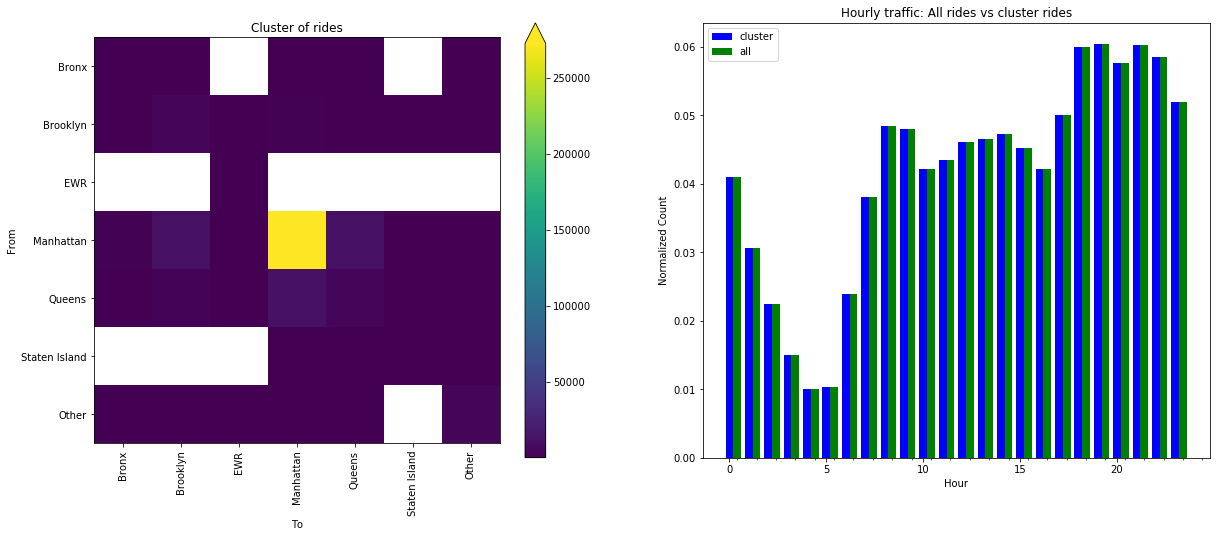

In [34]:
## generate the map
fig,ax = plt.subplots(1,2,figsize=(20,8))
im = ax[0].imshow(mat_cluster1)
ax[0].set_ylabel('From')
ax[0].set_xlabel('To')
ax[0].set_xticklabels(['','Bronx','Brooklyn','EWR','Manhattan','Queens','Staten Island','Other'],rotation='vertical')
ax[0].set_yticklabels(['', 'Bronx','Brooklyn','EWR','Manhattan','Queens','Staten Island','Other'])
ax[0].set_title('Cluster of rides')
fig.colorbar(im,ax=ax[0])
h = data.Pickup_hour.value_counts(normalize=True)
plt.bar(h.index,h.values,width = .4,color='b')
h = data_loc.Pickup_hour.value_counts(normalize=True)
ax[1].bar(h.index+.4,h.values,width = .4,color='g')
ax[1].set_title('Hourly traffic: All rides vs cluster rides')
ax[1].legend(['cluster','all'],loc='best')
ax[1].set_xlabel('Hour')
ax[1].set_xticks(np.arange(25)+.4,range(25))
ax[1].set_ylabel('Normalized Count')
plt.savefig('duration_cluster.jpeg',format='jpeg')
plt.show()

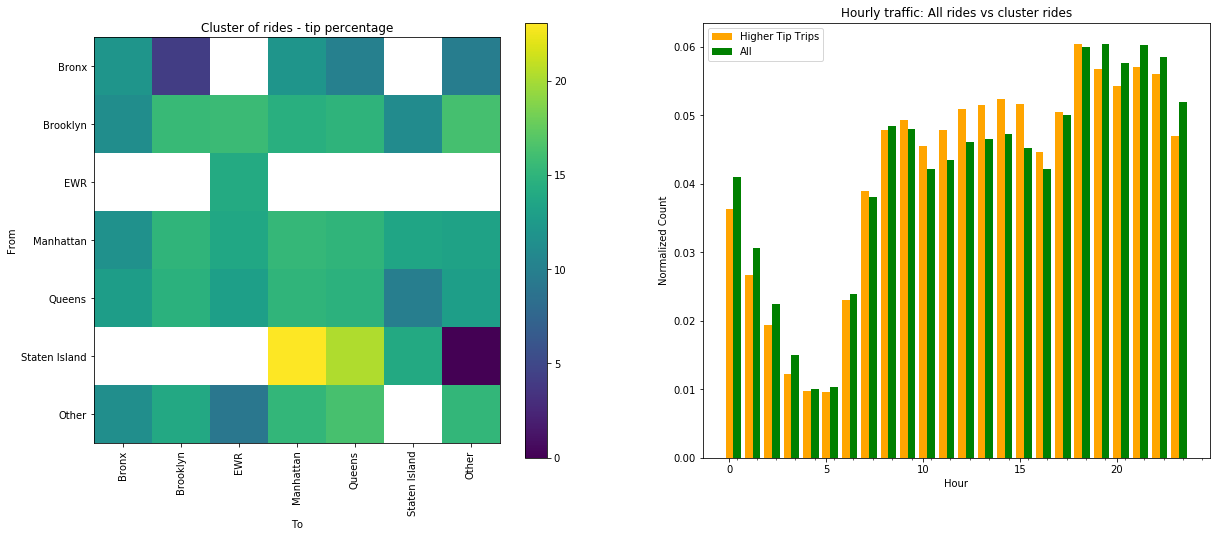

In [44]:
## generate the map
fig,ax = plt.subplots(1,2,figsize=(20,8))
im = ax[0].imshow(mat_cluster1)
ax[0].set_ylabel('From')
ax[0].set_xlabel('To')
ax[0].set_xticklabels(['','Bronx','Brooklyn','EWR','Manhattan','Queens','Staten Island','Other'],rotation='vertical')
ax[0].set_yticklabels(['', 'Bronx','Brooklyn','EWR','Manhattan','Queens','Staten Island','Other'])
ax[0].set_title('Cluster of rides - tip percentage')
fig.colorbar(im,ax=ax[0])
h = higher_tips.Pickup_hour.value_counts(normalize=True)
plt.bar(h.index,h.values,width = .4,color='orange')
h = data.Pickup_hour.value_counts(normalize=True)
ax[1].bar(h.index+.4,h.values,width = .4,color='green')
ax[1].set_title('Hourly traffic: All rides vs cluster rides')
ax[1].legend(['Higher Tip Trips','All'],loc='best')
ax[1].set_xlabel('Hour')
ax[1].set_xticks(np.arange(25)+.4,range(25))
ax[1].set_ylabel('Normalized Count')
plt.savefig('duration_cluster.jpeg',format='jpeg')
plt.show()